# Decision Trees

1. Information Gain

    Information Theory

    Entropy => $\sum -p \log (p)$

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [3]:
X = df.drop(['Target'], axis=1)
y = df['Target']

In [4]:
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def gini(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs**2)

In [5]:
entropy(y), gini(y)

(np.float64(1.498497439724364), np.float64(0.6277586455288842))

In [6]:
def best_split(X, y, criterion='gini'):
    best_feature, best_threshold, best_impurity = None, None, float('inf')
    impurity_func = gini if criterion == 'gini' else entropy

    for feature in tqdm(X.columns):
        unique_values = X[feature].unique()

        for value in unique_values:
            if np.issubdtype(X[feature].dtype, np.number):
                left_mask = (X[feature] <= value)
            else:
                left_mask = (X[feature] == value)
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            left_impurity = impurity_func(y[left_mask])
            right_impurity = impurity_func(y[right_mask])

            weighted_impurity = ((left_mask.sum() / len(y)) * left_impurity +
                                 (right_mask.sum() / len(y)) * right_impurity)

            if weighted_impurity < best_impurity:
                best_feature = feature
                best_threshold = value
                best_impurity = weighted_impurity
            
    return best_feature, best_threshold, best_impurity

In [7]:
selected_features = ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)',
                     'Previous qualification (grade)', 'Admission grade',
                     'Age at enrollment']

X_selected = X[selected_features]

In [9]:
best_split(X_selected, y)

100%|██████████| 5/5 [01:22<00:00, 16.54s/it]


('Curricular units 2nd sem (grade)',
 np.float64(10.5),
 np.float64(0.43577337913793224))

## Agac Kurulumu (Recursive)

In [8]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [9]:
def build_tree(X, y, depth=0, max_depth=3, criterion='gini'):
    if len(np.unique(y)) == 1 or depth >= max_depth:
        values, counts = np.unique(y, return_counts=True)
        return Node(value=values[np.argmax(counts)])

    feature, threshold, score = best_split(X, y, criterion=criterion)
    if feature is None:
        values, counts = values, counts = np.unique(y, return_counts=True)
        return Node(value=values[np.argmax(counts)])
    
    if X[feature].dtype == 'object':
        left_mask = (X[feature] == threshold)
    else:
        left_mask = (X[feature] <= threshold)
    right_mask = ~left_mask
    
    left = build_tree(X[left_mask], 
                      y[left_mask],
                      depth=depth+1,
                      max_depth=max_depth,
                      criterion=criterion)
    
    right = build_tree(X[right_mask], 
                      y[right_mask],
                      depth=depth+1,
                      max_depth=max_depth,
                      criterion=criterion)
    
    return Node(feature, threshold, left, right)


In [ ]:
def plot_decision_tree(node, depth=0, pos=None, parent_pos=None, text='', x_offset=0.5, y_offset=1.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('off')
        pos = (0.5, 1.0)  # Starting position

    # Label for the current node
    if node.value is not None:
        label = f'Leaf: {node.value}'
    else:
        label = f'{node.feature} ≤ {node.threshold}'

    # Draw current node
    ax.text(pos[0], pos[1], label, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue'))

    # Draw connecting line from parent to current node
    if parent_pos is not None:
        ax.plot([parent_pos[0], pos[0]], [parent_pos[1], pos[1]], 'k-')
        mid_x = (parent_pos[0] + pos[0]) / 2
        mid_y = (parent_pos[1] + pos[1]) / 2
        ax.text(mid_x, mid_y, text, fontsize=9)

    # Compute positions for children
    if node.left:
        left_x = pos[0] - x_offset / (2 ** depth)
        left_y = pos[1] - y_offset
        plot_decision_tree(node.left, depth + 1, (left_x, left_y), pos, 'Yes', x_offset, y_offset, ax)

    if node.right:
        right_x = pos[0] + x_offset / (2 ** depth)
        right_y = pos[1] - y_offset
        plot_decision_tree(node.right, depth + 1, (right_x, right_y), pos, 'No', x_offset, y_offset, ax)

    if depth == 0:
        plt.tight_layout()
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:27<00:00,  5.43s/it]
C:\Users\ogcicek\AppData\Local\Temp\ipykernel_23916\3073732374.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


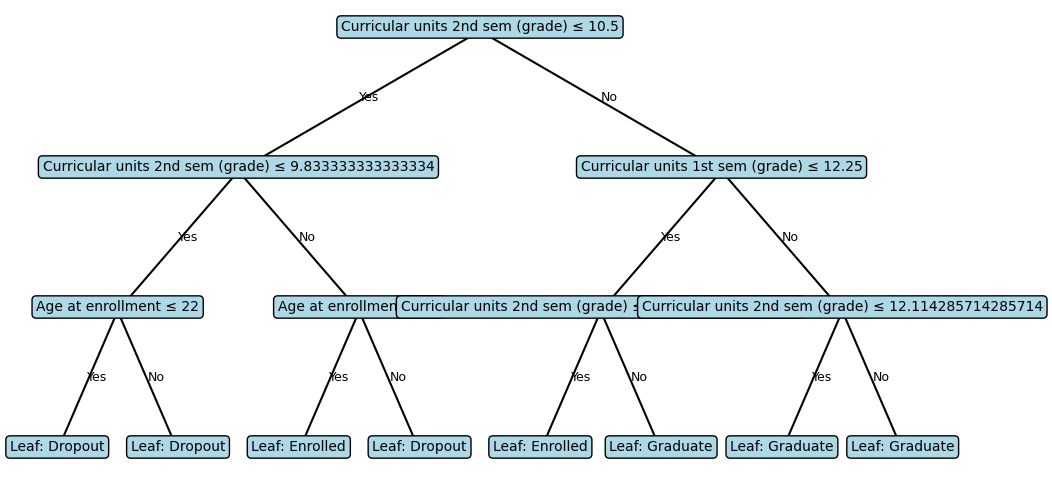

In [15]:
tree = build_tree(X_selected, y, depth=0)
plot_decision_tree(tree)